# Configuration of the architecture of the GO hidden layers of GraphGONet (step 2)

## Summary
The following notebook will construct the GO layers architecture based on the annotations previously extracted. <br>

#### Load packages

In [2]:
%config Completer.use_jedi = False

In [3]:
import networkx as nx
import obonet
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import sys
import random
from collections import Counter
from urllib.parse import urlparse

#### Set environnement

In [4]:
SUBONTOLOGY = "BP"

In [5]:
DATASET=input("Which dataset are you using? TCGA or microarray")

Which dataset are you using? TCGA or microarray TCGA


In [6]:
keyRef = "ENSEMBL" if DATASET=="TCGA" else "PROBE"

In [16]:
dir_data = "../data" #can be modified to your own path

In [8]:
dir_files = "../files" #can be modified to your own path

In [7]:
filename = os.path.join(dir_files,"id_genes.npz")

## 1. Preliminaries

### a) Study and Load Gene Ontology

To load the most recent version:

In [5]:
!wget http://purl.obolibrary.org/obo/go/go-basic.obo 

--2021-09-16 07:28:08--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 52.3.123.63
Connecting to purl.obolibrary.org (purl.obolibrary.org)|52.3.123.63|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2021-09-16 07:28:08--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 13.224.89.41, 13.224.89.174, 13.224.89.147, ...
Connecting to current.geneontology.org (current.geneontology.org)|13.224.89.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30901321 (29M) [text/obo]
Saving to: 'go-basic.obo'

go-basic.obo        100%[===================>]  29.47M  31.8MB/s    in 0.9s    

2021-09-16 07:28:09 (31.8 MB/s) - 'go-basic.obo' saved [30901321/30901321]



In [10]:
# Read the gene ontology
original_graph = obonet.read_obo(os.path.join(dir_files,'go-basic.obo'))

#### Characteristics

In [11]:
print(nx.info(original_graph))

Name: go
Type: MultiDiGraph
Number of nodes: 44411
Number of edges: 89323
Average in degree:   2.0113
Average out degree:   2.0113


- Number of initial nodes in the Gene Ontology

In [12]:
NB_NODES_TOTAL_ORIGINALLY=len(original_graph)
NB_NODES_TOTAL_ORIGINALLY

44411

- Number of edges

In [13]:
original_graph.number_of_edges()

89323

- Check if the graph is a DAG

In [14]:
nx.is_directed_acyclic_graph(original_graph)

True

### b) Load the previous annotations file

#### Load the gene input ID

In [17]:
loaded = np.load(filename,allow_pickle=True)
list_genes = loaded["genes"].astype(str).tolist()
list_genes

['ENSG00000000003',
 'ENSG00000000005',
 'ENSG00000000419',
 'ENSG00000000457',
 'ENSG00000000460',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001036',
 'ENSG00000001084',
 'ENSG00000001167',
 'ENSG00000001460',
 'ENSG00000001461',
 'ENSG00000001497',
 'ENSG00000001561',
 'ENSG00000001617',
 'ENSG00000001626',
 'ENSG00000001629',
 'ENSG00000001630',
 'ENSG00000001631',
 'ENSG00000002016',
 'ENSG00000002079',
 'ENSG00000002330',
 'ENSG00000002549',
 'ENSG00000002586',
 'ENSG00000002587',
 'ENSG00000002726',
 'ENSG00000002745',
 'ENSG00000002746',
 'ENSG00000002822',
 'ENSG00000002834',
 'ENSG00000002919',
 'ENSG00000002933',
 'ENSG00000003056',
 'ENSG00000003096',
 'ENSG00000003137',
 'ENSG00000003147',
 'ENSG00000003249',
 'ENSG00000003393',
 'ENSG00000003400',
 'ENSG00000003402',
 'ENSG00000003436',
 'ENSG00000003509',
 'ENSG00000003756',
 'ENSG00000003987',
 'ENSG00000003989',
 'ENSG00000004059',
 'ENSG00000004139',
 'ENSG00000004142',
 'ENSG00000004399',
 'ENSG00000004455',


#### Load the annotations

In [20]:
file_go_original = pd.read_csv(os.path.join(dir_files,"annotations-gene-GO.csv"),dtype={"GO":object,"ENTREZID":object})

In [21]:
file_go_original = file_go_original.dropna()
file_go_original = file_go_original[file_go_original.ONTOLOGY == SUBONTOLOGY]

In [22]:
file_go = file_go_original.drop(labels=['EVIDENCE','ENTREZID','ONTOLOGY'],axis=1)

In [23]:
file_go.head()

,ENSEMBL,GO
3,ENSG00000000003,GO:0039532
4,ENSG00000000003,GO:0043123
6,ENSG00000000003,GO:1901223
7,ENSG00000000005,GO:0001886
8,ENSG00000000005,GO:0001937


In [24]:
file_go.shape

(158050, 2)

#### Retrieve unique GO-BP terms (GO_target)

In [25]:
list_go = file_go.GO.unique()
list_go=list(list_go)

In [26]:
len(list_go)

12313

## 2. Extract the Gene Ontology subgraph based on the list of selected GO terms

We delete the nodes from the original graph (GO_ref) not included in our list of GO terms (GO_target). It includes the GO terms from the other subontologies, branches in the subontology of interest that do not involve GO terms in the list. Please note that we retain the ancestors of the GO terms in the list to have a weakly connected graph.

### a) List of GO-MF terms: $x |x \in \text{nodes}_{MF}\big[\text{GO_ref}\big]$

In [27]:
list_nodes_useless_MF = ["GO:0003674"]
list_nodes_useless_MF=list_nodes_useless_MF+list(nx.ancestors(original_graph, "GO:0003674"))
NB_NODES_USELESS_MF = len(list_nodes_useless_MF)
NB_NODES_USELESS_MF

11118

### b) List of GO-CC terms: $x |x \in \text{nodes}_{CC}\big[\text{GO_ref}\big]$

In [28]:
list_nodes_useless_CC = ["GO:0005575"]
list_nodes_useless_CC = list_nodes_useless_CC +list(nx.ancestors(original_graph, "GO:0005575"))
NB_NODES_USELESS_CC = len(list_nodes_useless_CC)
NB_NODES_USELESS_CC

4181

### c) List of GO-BP terms: $x |x \in \text{nodes}_{BP}\big[\text{GO_ref}\big]$

In [29]:
list_nodes_BP = ["GO:0008150"]
list_nodes_BP = list_nodes_BP +list(nx.ancestors(original_graph, "GO:0008150"))
NB_NODES_BP = len(list_nodes_BP)
NB_NODES_BP

29112

Total number of terms in the ontology:

In [30]:
NB_NODES_TOTAL_ORIGINALLY

44411

In [31]:
NB_NODES_USELESS_MF+NB_NODES_USELESS_CC+NB_NODES_BP

44411

### d) List of GO-BP terms that are not in our list and correspond to leaves in GO_ref: $x | x \in \text{leaf}_{BP}\big[\text{GO_ref} - (\text{GO_target} \wedge \text{GO_ref})\big]$

In [32]:
list_nodes_useless_cropped = [x for x in list_nodes_BP if original_graph.in_degree(x)==0 and x not in list_go]
NB_NODES_USELESS_BP = len(list_nodes_useless_cropped)
NB_NODES_USELESS_BP

7936

Number of GO terms from GO_target not included in GO_ref. *This is mainly due to version variations between the different packages.*
$x |x \in \text{GO_target} - (\text{GO_target} \wedge \text{GO_ref})$

In [33]:
list_go_target_removed = [x for x in list_go if x not in original_graph.nodes]
len(list_go_target_removed)

0

Total number of GO terms to delete in a first time:

In [34]:
NB_NODES_USELESS = NB_NODES_USELESS_MF+NB_NODES_USELESS_CC
NB_NODES_USELESS

15299

Total number of GO terms kept:

In [35]:
NB_NODES_TOTAL=NB_NODES_TOTAL_ORIGINALLY-NB_NODES_USELESS
NB_NODES_TOTAL

29112

### e) Update graph in a first time

In [36]:
import copy
graph = copy.deepcopy(original_graph)

In [37]:
print(nx.info(graph))

Name: go
Type: MultiDiGraph
Number of nodes: 44411
Number of edges: 89323
Average in degree:   2.0113
Average out degree:   2.0113


In [38]:
list_nodes_to_remove1 =list_nodes_useless_MF+list_nodes_useless_CC

In [39]:
graph.remove_nodes_from(list_nodes_to_remove1)

In [40]:
print(nx.info(graph))

Name: go
Type: MultiDiGraph
Number of nodes: 29112
Number of edges: 68989
Average in degree:   2.3698
Average out degree:   2.3698


- Check if the graph is still a DAG

In [41]:
nx.is_directed_acyclic_graph(graph)

True

- Check the connectivity of the graph

In [42]:
nx.is_weakly_connected(graph)

True

In [43]:
nx.is_strongly_connected(graph)

False

### f) Delete the ancestors of the leaf GO terms that are not in the GO_target list according to the transitivity principle

In [44]:
%%time
list_ancestors_to_remove,list_ancestors_to_keep=[],[]
for child in tqdm(list_nodes_useless_cropped):
    ancestors = nx.descendants(graph, child)
    for ancestor in ancestors:
        if (list_ancestors_to_remove.count(ancestor)==0) and (list_ancestors_to_keep.count(ancestor)==0):
            if list_go.count(ancestor)==0:
                descendants = list(nx.ancestors(graph, ancestor)) 
                if file_go.GO.isin(descendants).sum()==0:
                    list_ancestors_to_remove.append(ancestor)
                else:
                    list_ancestors_to_keep.append(ancestor)
            else:
                list_ancestors_to_keep.append(ancestor)

100%|██████████| 7936/7936 [01:13<00:00, 107.60it/s]

CPU times: user 1min 13s, sys: 112 ms, total: 1min 13s
Wall time: 1min 13s


In [45]:
len(list_ancestors_to_remove)

5114

In [46]:
list_ancestors_to_remove=np.unique(list_ancestors_to_remove)
list_ancestors_to_remove.shape[0]

5114

### g) Final update of the graph

In [47]:
NB_NODES_USELESS+= list_ancestors_to_remove.shape[0] + NB_NODES_USELESS_BP
NB_NODES_USELESS

28349

In [48]:
NB_NODES_TOTAL = NB_NODES_TOTAL_ORIGINALLY - NB_NODES_USELESS
NB_NODES_TOTAL

16062

In [49]:
graph.remove_nodes_from(list(list_ancestors_to_remove)+list_nodes_useless_cropped)

### Characteristics of this new graph

In [50]:
print(nx.info(graph))

Name: go
Type: MultiDiGraph
Number of nodes: 16062
Number of edges: 37406
Average in degree:   2.3289
Average out degree:   2.3289


- Check if the graph is still a DAG

In [51]:
nx.is_directed_acyclic_graph(graph)

True

- Check the connectivity of the graph

In [52]:
nx.is_weakly_connected(graph)

True

In [53]:
nx.is_strongly_connected(graph)

False

- Save the graph

In [63]:
%%time
nx.write_gpickle(graph,os.path.join(dir_files,"gobp-entire"))

CPU times: user 467 ms, sys: 60.1 ms, total: 527 ms
Wall time: 561 ms


- **in-degree** (descending sort)  

In [54]:
degree_in_sorted = sorted(list(graph.in_degree()), key=lambda tup: tup[1],reverse=True)
degree_in_sorted

[('GO:0048856', 131),
 ('GO:0051240', 87),
 ('GO:0051241', 82),
 ('GO:0009653', 71),
 ('GO:1901700', 66),
 ('GO:0009987', 64),
 ('GO:0014070', 59),
 ('GO:0009966', 58),
 ('GO:0048646', 58),
 ('GO:0048522', 56),
 ('GO:0048523', 55),
 ('GO:0006464', 54),
 ('GO:0030154', 54),
 ('GO:0050794', 54),
 ('GO:0003006', 52),
 ('GO:0065008', 51),
 ('GO:1901701', 51),
 ('GO:0009968', 47),
 ('GO:0032501', 46),
 ('GO:0051093', 46),
 ('GO:0009967', 44),
 ('GO:0022402', 43),
 ('GO:0051094', 42),
 ('GO:0071407', 42),
 ('GO:2000026', 42),
 ('GO:0006259', 41),
 ('GO:0022414', 41),
 ('GO:0001816', 40),
 ('GO:0048598', 40),
 ('GO:0001817', 39),
 ('GO:0010243', 39),
 ('GO:0022412', 39),
 ('GO:0019221', 38),
 ('GO:0034622', 38),
 ('GO:0051239', 37),
 ('GO:1901564', 37),
 ('GO:0007186', 36),
 ('GO:0048513', 36),
 ('GO:1901360', 36),
 ('GO:0044237', 35),
 ('GO:0048519', 35),
 ('GO:1901566', 35),
 ('GO:0001819', 34),
 ('GO:0006810', 34),
 ('GO:1903047', 34),
 ('GO:0006790', 32),
 ('GO:0007165', 32),
 ('GO:001003

In [55]:
dfInfoGraph=pd.DataFrame(dict(graph.in_degree()).values(),columns={"d-"})

- **out-degree** (descending sort)  

In [56]:
degree_out_sorted = sorted(list(graph.out_degree()), key=lambda tup: tup[1],reverse=True)
degree_out_sorted

[('GO:0060520', 10),
 ('GO:1900245', 9),
 ('GO:1900246', 9),
 ('GO:0030974', 8),
 ('GO:0044598', 8),
 ('GO:0045829', 8),
 ('GO:0045830', 8),
 ('GO:0060266', 8),
 ('GO:0072040', 8),
 ('GO:1900133', 8),
 ('GO:1901753', 8),
 ('GO:1904024', 8),
 ('GO:0006127', 7),
 ('GO:0006768', 7),
 ('GO:0010905', 7),
 ('GO:0043456', 7),
 ('GO:0045727', 7),
 ('GO:0045820', 7),
 ('GO:0045821', 7),
 ('GO:0060265', 7),
 ('GO:0060297', 7),
 ('GO:0060298', 7),
 ('GO:0060299', 7),
 ('GO:0061051', 7),
 ('GO:0061052', 7),
 ('GO:0070949', 7),
 ('GO:0070961', 7),
 ('GO:0072039', 7),
 ('GO:0090153', 7),
 ('GO:1900052', 7),
 ('GO:1900053', 7),
 ('GO:1900054', 7),
 ('GO:1900126', 7),
 ('GO:1900127', 7),
 ('GO:1901164', 7),
 ('GO:1901165', 7),
 ('GO:1903595', 7),
 ('GO:1905304', 7),
 ('GO:1905305', 7),
 ('GO:1905312', 7),
 ('GO:2000703', 7),
 ('GO:2000734', 7),
 ('GO:0001675', 6),
 ('GO:0003340', 6),
 ('GO:0003420', 6),
 ('GO:0006110', 6),
 ('GO:0010759', 6),
 ('GO:0010900', 6),
 ('GO:0010904', 6),
 ('GO:0010919', 6),

In [57]:
dfInfoGraph["d+"]=dict(graph.out_degree()).values()

- **degree** (descending sort)

In [58]:
degree_graph = graph.degree()
sorted_nodes_degree = sorted(list(degree_graph), key=lambda tup: tup[1],reverse=True)
sorted_nodes_degree

[('GO:0048856', 132),
 ('GO:0051240', 90),
 ('GO:0051241', 85),
 ('GO:0009653', 73),
 ('GO:1901700', 67),
 ('GO:0009987', 65),
 ('GO:0009966', 62),
 ('GO:0014070', 60),
 ('GO:0048646', 60),
 ('GO:0048522', 59),
 ('GO:0048523', 58),
 ('GO:0006464', 56),
 ('GO:0050794', 56),
 ('GO:0030154', 55),
 ('GO:0003006', 54),
 ('GO:1901701', 53),
 ('GO:0009968', 52),
 ('GO:0065008', 52),
 ('GO:0009967', 49),
 ('GO:0051093', 49),
 ('GO:0032501', 47),
 ('GO:0022402', 45),
 ('GO:0051094', 45),
 ('GO:2000026', 45),
 ('GO:0071407', 44),
 ('GO:0006259', 43),
 ('GO:0022414', 43),
 ('GO:0001816', 42),
 ('GO:0001817', 42),
 ('GO:0022412', 42),
 ('GO:0048598', 42),
 ('GO:0010243', 41),
 ('GO:0019221', 40),
 ('GO:0034622', 39),
 ('GO:0051239', 39),
 ('GO:1901564', 39),
 ('GO:0001819', 38),
 ('GO:0048513', 38),
 ('GO:0007165', 37),
 ('GO:0007186', 37),
 ('GO:0044237', 37),
 ('GO:0048519', 37),
 ('GO:1901360', 37),
 ('GO:1901566', 37),
 ('GO:1903047', 36),
 ('GO:0001818', 35),
 ('GO:0006810', 35),
 ('GO:002260

In [59]:
dfInfoGraph["d"]=dict(graph.degree()).values()

In [60]:
dfInfoGraph.describe()

,d-,d+,d
count,16062.000000,16062.000000,16062.000000
mean,2.328851,2.328851,4.657701
std,4.266356,1.086480,4.324388
min,0.000000,0.000000,1.000000
25%,0.000000,2.000000,3.000000
50%,1.000000,2.000000,4.000000
75%,3.000000,3.000000,5.000000
max,131.000000,10.000000,132.000000


- **Level max**

In [61]:
NB_LEVELS = nx.dag_longest_path_length(graph) + 1
NB_LEVELS

20

- List nodes with their degree and their level

In [62]:
def compute_level(goid,graph=graph,root="GO:0008150"):
    if goid!=root :
        return len(max(nx.all_simple_paths(graph, i, root), key=lambda x: len(x)))-1
    else:
        return 0

In [63]:
%%time
df_depth_target = dict()
for i in graph.nodes:
    df_depth_target[i] = compute_level(i)

CPU times: user 19 s, sys: 11.3 ms, total: 19 s
Wall time: 19 s


In [64]:
df_depth_target = pd.DataFrame.from_dict(df_depth_target,orient='index')

In [65]:
df_depth_target.rename(index=str, columns={0: "root"},inplace=True)

In [66]:
df_depth_target.isna().sum()

root    0
dtype: int64

In [67]:
NB_LEVELS= np.max(df_depth_target.root.values) + 1
NB_LEVELS

20

In [68]:
%%time
degree_by_level_in,degree_by_level_out=list(),list()
for node in df_depth_target.index:
    degree_by_level_in.append(graph.in_degree(node))
    degree_by_level_out.append(graph.out_degree(node))
df_depth_target["d+"]=degree_by_level_out
df_depth_target["d-"]=degree_by_level_in

CPU times: user 66.9 ms, sys: 33 µs, total: 66.9 ms
Wall time: 66.2 ms


In [69]:
df_depth_target.head()

,root,d+,d-
GO:0000002,6,1,1
GO:0000003,1,1,4
GO:0000012,8,1,4
GO:0000017,8,1,0
GO:0000018,8,2,8


In [70]:
df_depth_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16062 entries, GO:0000002 to GO:2001311
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   root    16062 non-null  int64
 1   d+      16062 non-null  int64
 2   d-      16062 non-null  int64
dtypes: int64(3)
memory usage: 501.9+ KB


In [87]:
df_depth_target.to_csv(os.path.join(dir_files,"go_to_level_entire.csv"))

In [71]:
import matplotlib.pyplot as plt

In [72]:
df_depth_target.groupby("root").size()

root
0        1
1       23
2      125
3      338
4      730
5     1311
6     1836
7     2133
8     2328
9     2232
10    1839
11    1407
12     862
13     464
14     237
15     114
16      55
17      21
18       5
19       1
dtype: int64

([<matplotlib.axis.YTick at 0x7f6ba2aa5dd8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

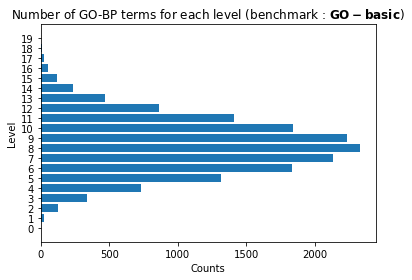

In [73]:
barlist=plt.barh(y=np.arange(NB_LEVELS),width=df_depth_target.groupby("root").size().values)
plt.title('Number of GO-BP terms for each level (benchmark : '+ r'$\bf{GO-basic}$'+')')
plt.xlabel("Counts")
plt.ylabel("Level")
plt.yticks(np.arange(NB_LEVELS))

In [74]:
gp=df_depth_target.groupby("root")

In [75]:
mlevel_degree=np.array([])
for idx in np.arange(1,gp.ngroups):
    tmp=gp.get_group(idx)[["d+","d-"]].describe().values
    mlevel_degree = np.hstack([mlevel_degree, tmp]) if mlevel_degree.size else tmp
df_level_degree=pd.DataFrame(mlevel_degree,index=gp.get_group(idx)[["d+","d-"]].describe().index)
df_level_degree.columns = pd.MultiIndex.from_product([range(1,gp.ngroups),['d+','d-']])

In [76]:
df_level_degree

1                      2                       3               \
         d+         d-          d+          d-          d+          d-   
count  23.0  23.000000  125.000000  125.000000  338.000000  338.000000   
mean    1.0  12.913043    1.200000    7.904000    1.331361    6.961538   
std     0.0  15.335381    0.421212   13.810599    0.513577   10.237028   
min     1.0   1.000000    1.000000    0.000000    1.000000    0.000000   
25%     1.0   3.500000    1.000000    2.000000    1.000000    1.000000   
50%     1.0   8.000000    1.000000    5.000000    1.000000    3.000000   
75%     1.0  18.500000    1.000000    9.000000    2.000000    7.000000   
max     1.0  64.000000    3.000000  131.000000    3.000000   71.000000   

               4                        5                ...          15  \
               d+          d-           d+           d-  ...          d+   
count  730.000000  730.000000  1311.000000  1311.000000  ...  114.000000   
mean     1.679452    5.775342     1.921434     3.799390  ...    3.184211   
std      0.790020    9.181238     0.945422     5.355616  ...    1.223413   
min      1.000000    0.000000     1.000000     0.000000  ...    1.000000   
25%      1.000000    1.000000     1.000000     1.000000  ...    2.000000   
50%      2.000000    3.000000     2.000000     2.000000  ...    3.000000   
75%      2.000000    7.000000     2.000000     5.000000  ...    4.000000   
max      5.000000   87.000000     6.000000    58.000000  ...    6.000000   

                          16                    17                   18  \
               d-         d+         d-         d+         d-        d+   
count  114.000000  55.000000  55.000000  21.000000  21.000000  5.000000   
mean     0.859649   3.581818   0.618182   3.619048   0.333333  2.800000   
std      1.127902   1.117055   0.952403   1.596126   0.658281  1.095445   
min      0.000000   1.000000   0.000000   2.000000   0.000000  2.000000   
25%      0.000000   3.000000   0.000000   2.000000   0.000000  2.000000   
50%      0.000000   4.000000   0.000000   4.000000   0.000000  2.000000   
75%      1.750000   4.000000   1.000000   4.000000   0.000000  4.000000   
max      5.000000   6.000000   3.000000   7.000000   2.000000  4.000000   

                  19       
             d-   d+   d-  
count  5.000000  1.0  1.0  
mean   0.200000  2.0  0.0  
std    0.447214  NaN  NaN  
min    0.000000  2.0  0.0  
25%    0.000000  2.0  0.0  
50%    0.000000  2.0  0.0  
75%    0.000000  2.0  0.0  
max    1.000000  2.0  0.0  

[8 rows x 38 columns]

## 3. Last clean: prune connections between the graph and the genes and save

In [77]:
file_go.head()

,ENSEMBL,GO
3,ENSG00000000003,GO:0039532
4,ENSG00000000003,GO:0043123
6,ENSG00000000003,GO:1901223
7,ENSG00000000005,GO:0001886
8,ENSG00000000005,GO:0001937


Number of initial annotations

In [78]:
file_go.shape[0]

158050

### a) Remove redundancies

In [79]:
file_go=file_go.drop_duplicates()

In [80]:
file_go.shape[0]

142799

### b) Remove the rows where it implies a GO term that does not belong to the final graph

In [81]:
indexNames = file_go[file_go['GO'].isin(list_go_target_removed)].index

In [82]:
indexNames.shape

(0,)

In [83]:
file_go.drop(index=indexNames,inplace=True)

In [84]:
file_go.shape[0]

142799

### c) Remove the rows whose GO terms have descendants connected to the same genes

In [85]:
%%time
gp=file_go.groupby(keyRef)
for ensembl in list(gp.groups.keys()):
    go_associated=gp.get_group(ensembl)["GO"].tolist()
    indexes = list(gp.groups[ensembl])
    current_idx=0
    while current_idx<len(go_associated):
        go_visited = go_associated[current_idx]
        idx = indexes.pop(0)
        successors = set(nx.ancestors(graph, go_visited))
        if len(successors.intersection(set(go_associated)))!=0:
            file_go=file_go.drop(idx)
            keep1=go_visited
            keep2=idx
        current_idx+=1

CPU times: user 2min 44s, sys: 415 ms, total: 2min 45s
Wall time: 2min 45s


Number of annotations kept:

In [86]:
file_go.shape[0]

116926

Number of genes annotated:

In [87]:
np.unique(file_go[keyRef]).shape[0]

18427

Number of GO terms annotated:

In [88]:
np.unique(file_go.GO).shape[0]

12002

In [129]:
file_go.to_csv(os.path.join(dir_files,"GOannotations_kept.csv"))

### d) Create the adjacency matrix between genes and GO terms

In [89]:
gp_go=file_go.groupby("GO")

In [90]:
gp_go.ngroups

12002

In [91]:
%%time
to_remove = list(set(list_genes) - set(np.unique(file_go[keyRef])))
for geneid in to_remove:
    list_genes.remove(geneid)
#to keep the order

CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.8 s


In [92]:
len(list_genes)

18427

In [93]:
matrix_connection = pd.DataFrame(index=list_genes,columns=list(gp_go.groups.keys()))
matrix_connection = matrix_connection.fillna(0)
matrix_connection.head()

,GO:0000002,GO:0000003,GO:0000012,GO:0000017,GO:0000018,GO:0000019,GO:0000023,GO:0000027,GO:0000028,GO:0000032,...,GO:2001280,GO:2001286,GO:2001287,GO:2001288,GO:2001294,GO:2001295,GO:2001301,GO:2001303,GO:2001306,GO:2001311
ENSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
matrix_connection.shape

(18427, 12002)

In [95]:
%%time
for go in gp_go.groups.keys():
    geneids=gp_go.get_group(go)[keyRef].tolist()
    matrix_connection.loc[geneids,go]=1

CPU times: user 6.25 s, sys: 164 ms, total: 6.41 s
Wall time: 6.38 s


In [277]:
matrix_connection.to_csv(os.path.join(dir_files,"matrix_connection_entire.csv"))